### importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath(os.path.join("../script")))
from utils import percent_missing,format_float, find_agg, missing_values_table,convert_bytes_to_megabytes,fix_missing_ffill,fix_missing_bfill

In [2]:
from sqlalchemy import create_engine

database_name = 'week1'
table_name= 'xdr_data'

connection_params = { "host": "localhost", "user": "postgres", "password": "pgadmin",
                    "port": "5432", "database": database_name}

engine = create_engine(f"postgresql+psycopg2://{connection_params['user']}:{connection_params['password']}@{connection_params['host']}:{connection_params['port']}/{connection_params['database']}")

# str or SQLAlchemy Selectable (select or text object)
sql_query = 'SELECT * FROM xdr_data'

df = pd.read_sql(sql_query, con= engine)

In [3]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [4]:
selected_columns = [
    'MSISDN/Number',
    'TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)',
    'Avg RTT DL (ms)', 'Avg RTT UL (ms)',
    'Avg Bearer TP UL (kbps)', 'Avg Bearer TP DL (kbps)',
    'Handset Type']

In [5]:
selected_df = df[selected_columns]
selected_df

,MSISDN/Number,TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP UL (kbps),Avg Bearer TP DL (kbps),Handset Type
0,3.366496e+10,NaN,NaN,42.0,5.0,44.0,23.0,Samsung Galaxy A5 Sm-A520F
1,3.368185e+10,NaN,NaN,65.0,5.0,26.0,16.0,Samsung Galaxy J5 (Sm-J530)
2,3.376063e+10,NaN,NaN,NaN,NaN,9.0,6.0,Samsung Galaxy A8 (2018)
3,3.375034e+10,NaN,NaN,NaN,NaN,44.0,44.0,undefined
4,3.369980e+10,NaN,NaN,NaN,NaN,9.0,6.0,Samsung Sm-G390F
...,...,...,...,...,...,...,...,...
149996,3.365069e+10,NaN,NaN,32.0,0.0,65.0,52.0,Apple iPhone 8 Plus (A1897)
149997,3.366345e+10,NaN,NaN,27.0,2.0,54.0,23.0,Apple iPhone Se (A1723)
149998,3.362189e+10,NaN,NaN,43.0,6.0,47.0,43.0,Apple iPhone Xs (A2097)
149999,3.361962e+10,NaN,NaN,37.0,5.0,37.0,34.0,Huawei Fig-Lx1


In [6]:
# Replace missing values with the mean for numerical columns (TCP retransmission, RTT, throughput)
numeric_columns = ['TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
                   'Avg RTT DL (ms)', 'Avg RTT UL (ms)',
                   'Avg Bearer TP UL (kbps)', 'Avg Bearer TP DL (kbps)']

for col in numeric_columns:
    df[col].fillna(df[col].mean(), inplace=True)

# Replace missing handset type values with the mode (most frequent)
df['Handset Type'].fillna(df['Handset Type'].mode()[0], inplace=True)

# Aggregate information per customer
aggregated_data = df.groupby('MSISDN/Number').agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'TCP UL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Avg RTT UL (ms)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean',
    'Avg Bearer TP DL (kbps)': 'mean',
    'Handset Type': lambda x: x.mode()[0]  # Get the most frequent handset type per customer
}).reset_index()

# Displaying the aggregated data
aggregated_data


,MSISDN/Number,TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP UL (kbps),Avg Bearer TP DL (kbps),Handset Type
0,3.360100e+10,2.080991e+07,759658.664811,46.000000,0.000000,39.0,37.0,Huawei P20 Lite Huawei Nova 3E
1,3.360100e+10,2.080991e+07,759658.664811,30.000000,1.000000,51.0,48.0,Apple iPhone 7 (A1778)
2,3.360100e+10,2.080991e+07,759658.664811,109.795706,17.662883,49.0,48.0,undefined
3,3.360101e+10,1.066000e+03,759658.664811,69.000000,15.000000,44.0,204.0,Apple iPhone 5S (A1457)
4,3.360101e+10,1.507977e+07,390430.332406,57.000000,2.500000,8224.5,20197.5,Apple iPhone Se (A1723)
...,...,...,...,...,...,...,...,...
106851,3.379000e+10,2.150440e+05,3001.000000,42.000000,10.000000,387.0,9978.0,Huawei Honor 9 Lite
106852,3.379000e+10,2.080991e+07,759658.664811,34.000000,6.000000,48.0,68.0,Apple iPhone 8 Plus (A1897)
106853,3.197021e+12,2.080991e+07,759658.664811,109.795706,17.662883,0.0,1.0,Quectel Wireless. Quectel Ec25-E
106854,3.370000e+14,2.080991e+07,759658.664811,109.795706,17.662883,22.0,11.0,Huawei B525S-23A


# Top, bottom, and most frequent values for TCP, RTT, and Throughput

In [7]:
# Task 4.2 - Top, bottom, and most frequent values for TCP, RTT, and Throughput
top_10_TCP = df['TCP DL Retrans. Vol (Bytes)'].nlargest(10)
bottom_10_TCP = df['TCP DL Retrans. Vol (Bytes)'].nsmallest(10)
most_frequent_TCP = df['TCP DL Retrans. Vol (Bytes)'].value_counts().head(10)

top_10_RTT = df['Avg RTT DL (ms)'].nlargest(10)
bottom_10_RTT = df['Avg RTT DL (ms)'].nsmallest(10)
most_frequent_RTT = df['Avg RTT DL (ms)'].value_counts().head(10)

top_10_throughput = df['Avg Bearer TP DL (kbps)'].nlargest(10)
bottom_10_throughput = df['Avg Bearer TP DL (kbps)'].nsmallest(10)
most_frequent_throughput = df['Avg Bearer TP DL (kbps)'].value_counts().head(10)


In [8]:
top_10_TCP

77979     4.294426e+09
135678    4.291380e+09
34645     4.289877e+09
140813    4.289488e+09
3782      4.288060e+09
119684    4.275259e+09
39637     4.268432e+09
76990     4.259997e+09
59016     4.256650e+09
41209     4.254644e+09
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

In [9]:
bottom_10_TCP

59717     2.0
125094    2.0
2850      4.0
39610     4.0
52488     4.0
60376     4.0
60426     4.0
75093     4.0
100314    4.0
143429    4.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

In [10]:
most_frequent_TCP

TCP DL Retrans. Vol (Bytes)
2.080991e+07    88146
1.330000e+03      433
2.660000e+03      219
3.800000e+01      200
9.200000e+01      192
1.318000e+03      156
5.430000e+02      133
3.990000e+03      114
7.600000e+01      108
5.320000e+03      102
Name: count, dtype: int64

In [11]:
top_10_RTT

30166     96923.0
29927     64640.0
17910     55811.0
5989      54847.0
22851     26971.0
23455     26250.0
1373      25873.0
81274     25602.0
97321     25374.0
100584    24733.0
Name: Avg RTT DL (ms), dtype: float64

In [12]:
bottom_10_RTT

42612     0.0
52225     0.0
60152     0.0
61152     0.0
61345     0.0
103328    0.0
124544    0.0
142526    0.0
143878    0.0
71739     2.0
Name: Avg RTT DL (ms), dtype: float64

In [13]:
most_frequent_RTT

Avg RTT DL (ms)
109.795706    27829
28.000000      3553
27.000000      3380
34.000000      3296
35.000000      2892
37.000000      2718
36.000000      2645
38.000000      2547
29.000000      2498
26.000000      2488
Name: count, dtype: int64

In [14]:
top_10_throughput

120890    378160.0
141262    299257.0
143670    299002.0
149617    276040.0
92193     269362.0
117791    266332.0
115850    265440.0
89577     264448.0
116565    263047.0
41576     254253.0
Name: Avg Bearer TP DL (kbps), dtype: float64

In [15]:
bottom_10_throughput

13      0.0
149     0.0
364     0.0
546     0.0
618     0.0
679     0.0
756     0.0
809     0.0
893     0.0
1185    0.0
Name: Avg Bearer TP DL (kbps), dtype: float64

In [16]:
most_frequent_throughput

Avg Bearer TP DL (kbps)
23.0    7324
43.0    4352
44.0    4186
6.0     3983
22.0    2867
48.0    2778
63.0    2757
42.0    2689
45.0    2644
47.0    2263
Name: count, dtype: int64

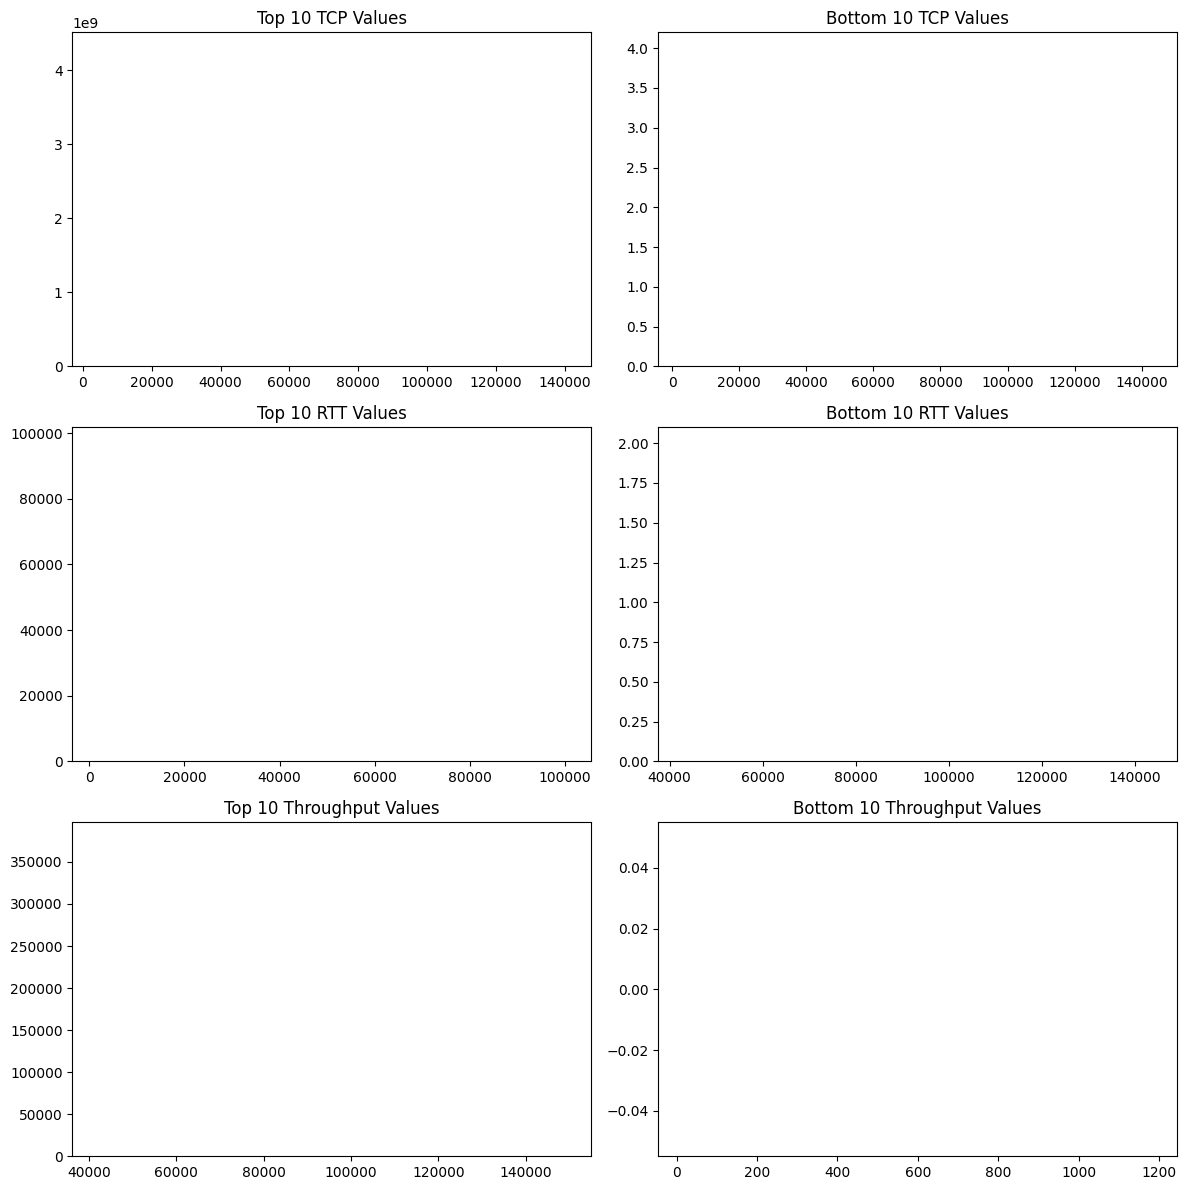

In [17]:
# Plotting graphs for top and bottom values
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# TCP top and bottom values
axs[0, 0].bar(top_10_TCP.index, top_10_TCP.values)
axs[0, 0].set_title('Top 10 TCP Values')
axs[0, 1].bar(bottom_10_TCP.index, bottom_10_TCP.values)
axs[0, 1].set_title('Bottom 10 TCP Values')

# RTT top and bottom values
axs[1, 0].bar(top_10_RTT.index, top_10_RTT.values)
axs[1, 0].set_title('Top 10 RTT Values')
axs[1, 1].bar(bottom_10_RTT.index, bottom_10_RTT.values)
axs[1, 1].set_title('Bottom 10 RTT Values')

# Throughput top and bottom values
axs[2, 0].bar(top_10_throughput.index, top_10_throughput.values)
axs[2, 0].set_title('Top 10 Throughput Values')
axs[2, 1].bar(bottom_10_throughput.index, bottom_10_throughput.values)
axs[2, 1].set_title('Bottom 10 Throughput Values')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

### Task Average TCP retransmission view per handset type

In [19]:
avg_TCP_retransmission_per_handset = df.groupby('Handset Type')['TCP DL Retrans. Vol (Bytes)'].mean().reset_index()
print("Average TCP retransmission per handset type:")
avg_TCP_retransmission_per_handset

Average TCP retransmission per handset type:


,Handset Type,TCP DL Retrans. Vol (Bytes)
0,A-Link Telecom I. Cubot A5,2.080991e+07
1,A-Link Telecom I. Cubot Note Plus,6.023490e+05
2,A-Link Telecom I. Cubot Note S,4.134448e+07
3,A-Link Telecom I. Cubot Nova,1.358400e+05
4,A-Link Telecom I. Cubot Power,7.799000e+03
...,...,...
1391,Zte Zte Blade C2 Smartphone Android By Sfr Sta...,1.040629e+07
1392,Zyxel Communicat. Lte7460,2.384303e+07
1393,Zyxel Communicat. Sbg3600,5.020084e+07
1394,Zyxel Communicat. Zyxel Wah7706,1.160000e+02


### Plotting average TCP retransmission per handset type

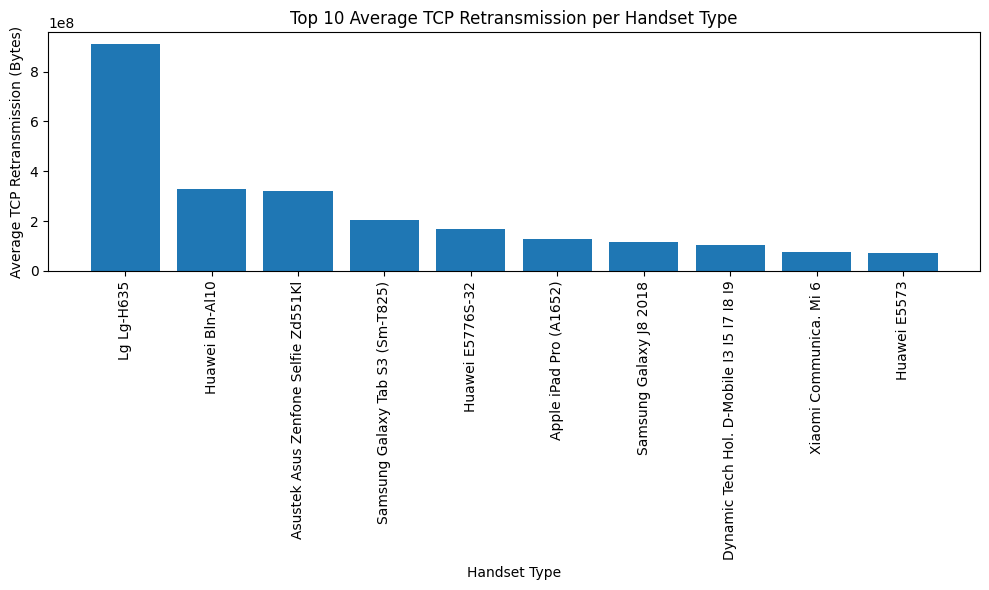

In [22]:
# Sort by average TCP retransmission and select top 10
top_10_TCP_retransmission = avg_TCP_retransmission_per_handset.nlargest(10, 'TCP DL Retrans. Vol (Bytes)')

# Plotting top 10 average TCP retransmission per handset type
plt.figure(figsize=(10, 6))
plt.bar(top_10_TCP_retransmission['Handset Type'], top_10_TCP_retransmission['TCP DL Retrans. Vol (Bytes)'])
plt.xticks(rotation=90)
plt.xlabel('Handset Type')
plt.ylabel('Average TCP Retransmission (Bytes)')
plt.title('Top 10 Average TCP Retransmission per Handset Type')
plt.tight_layout()
plt.show()

# K-means clustering to segment users into groups of experiences (k=3)

In [24]:

# Selecting features for clustering
features = ['TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)']
X = df[features]

# Performing K-means clustering
kmeans = KMeans(n_clusters=3)
df['Cluster'] = kmeans.fit_predict(X)

# Description of each cluster
cluster_description = df.groupby('Cluster')[features].mean()
print("Description of each cluster based on experience metrics:")
cluster_description

/home/oli/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Description of each cluster based on experience metrics:


,TCP DL Retrans. Vol (Bytes),Avg RTT DL (ms),Avg Bearer TP DL (kbps)
Cluster,,,
0,1.567623e+07,109.782333,13178.862788
1,1.273892e+09,117.704167,58806.204167
2,3.221750e+09,110.500000,62679.068493


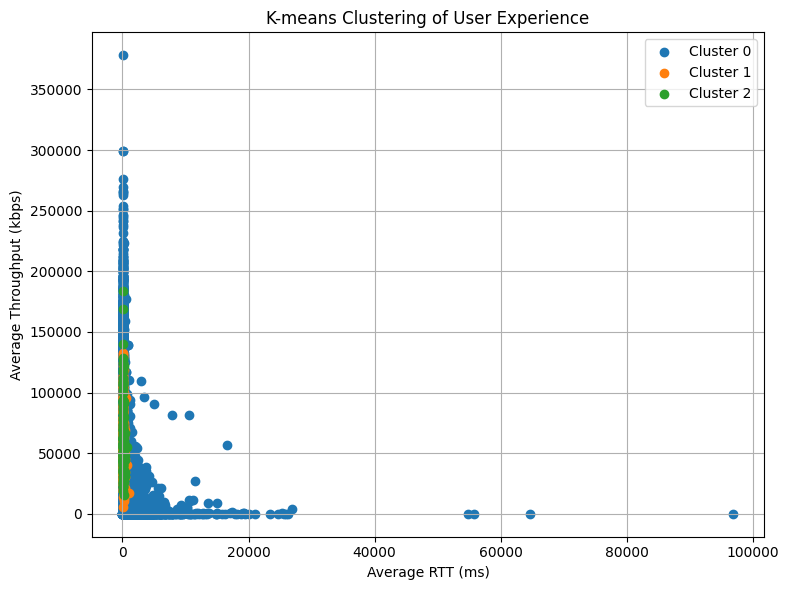

In [25]:
# Scatter plot for clustering visualization
plt.figure(figsize=(8, 6))
for cluster_label in range(3):
    cluster_data = df[df['Cluster'] == cluster_label]
    plt.scatter(cluster_data['Avg RTT DL (ms)'], cluster_data['Avg Bearer TP DL (kbps)'],
                label=f'Cluster {cluster_label}')

plt.xlabel('Average RTT (ms)')
plt.ylabel('Average Throughput (kbps)')
plt.title('K-means Clustering of User Experience')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()